In [1]:
using Makie
using GLMakie
using Makie.GeometryBasics
using CUDA
using Ananke
using TimerOutputs
#debug Timer
TimerOutputs.enable_debug_timings(Ananke)
Ananke.timeit_debug_enabled()

true

# 3D Sod Tube with PPM

In [2]:
Nx,Ny,Nz = 256,256,256;
nx,ny,nz = 256,256,256;
Lx,Ly,Lz = [0,1],[0,1],[0,1];
nothingfunction(args...) = nothing;
prob = ProblemConstrcut(  ; N = (Nx,Ny,Nz),
                            n = (nx,ny,nz),
                           Lx = Lx,
                           Ly = Lx,
                           Lz = Lx,
                 SpatialOrder = 3,  
                   TimelOrder = 2,
                           T  = Float32,
                       Bfield = false,
                       Nghost = 4,
                      EOSType = "Adiabatic",
                     Boundary = ["Outflow","Outflow",
                                 "Outflow","Outflow",
                                 "Outflow","Outflow"],
                      usr_foo = nothingfunction);

In [3]:
function pgen_Sod3D!(prob)
  grid     = prob.grid;
  nx,ny,nz = grid.Nx,grid.Ny,grid.Nz;
  x1,x2,x3 = grid.x1,grid.x2,grid.x3;

  IDN,IEN,IPR  = prob.grid.ind.ρ ,prob.grid.ind.e ,prob.grid.ind.P;
  IVX,IVY,IVZ  = prob.grid.ind.v₁,prob.grid.ind.v₂,prob.grid.ind.v₃;
  nx,ny,nz = prob.grid.nx,prob.grid.ny,prob.grid.nz;
    
  P = zeros(eltype(grid),size(prob.sol.U)[1:3]);
  ρ = zeros(eltype(grid),size(prob.sol.U)[1:3]);
  ρL = 1.0;
  PL = 1.0;
  ρR = 0.125;
  PR = 0.1;
  x,y,z = x1.x1f,x2.x2f,x3.x3f
  nx,ny,nz = size(prob.sol.U)[1:3]
  xpypz =  reshape(x,(nx,1,1)) .+ reshape(y,(1,ny,1)) .+ reshape(z,(1,1,nz))
  @.  ρ[ xpypz.<1.0] = ρL;
  @.  P[ xpypz.<1.0] = PL;
  @.  ρ[xpypz.>=1.0] = ρR;
  @.  P[xpypz.>=1.0] = PR;
  SetUpProblemIC!(prob;  ρ = ρ,  p = P)
  return nothing
end

pgen_Sod3D! (generic function with 1 method)

In [4]:
pgen_Sod3D!(prob)

In [5]:
w = Array(prob.sol.W);
wl= Array(prob.tmp.wl);
wr= Array(prob.tmp.wr);
 F= Array(prob.flux.F);
IDN,IEN,IPR  = prob.grid.ind.ρ::Int ,prob.grid.ind.e::Int ,prob.grid.ind.P::Int ;
IVX,IVY,IVZ  = prob.grid.ind.v₁::Int,prob.grid.ind.v₂::Int,prob.grid.ind.v₃::Int;
is,ie = prob.grid.x1.is::Int,prob.grid.x1.ie::Int;
js,je = prob.grid.x2.js::Int,prob.grid.x2.je::Int;
ks,ke = prob.grid.x3.ks::Int,prob.grid.x3.ke::Int;

d =  w[is:ie,js:je,ks:ke,IDN];

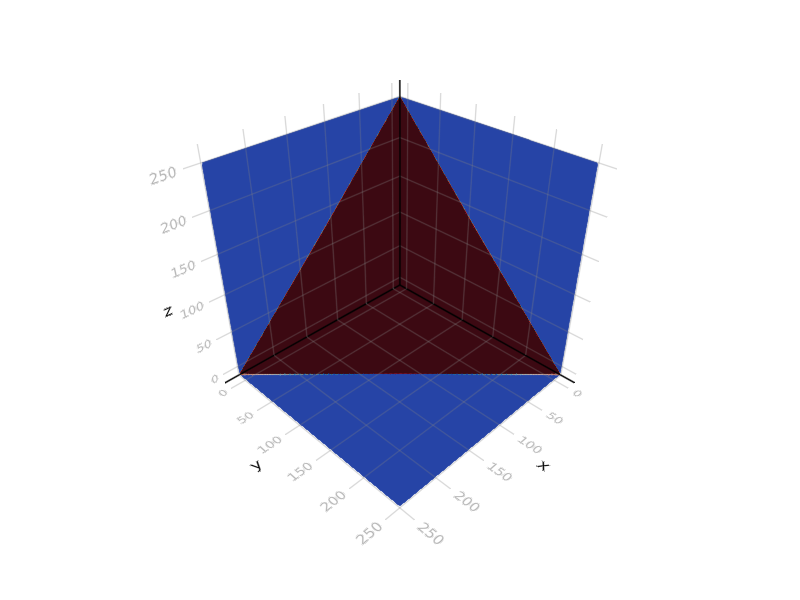

In [6]:
GLMakie.activate!() # hide
inline!(true) # hide

colormap = Makie.to_colormap(:balance)
colormap[1] = RGBAf0(0.0,0.0,0.0,0.0)
scene = GLMakie.volume(d,algorithm =:mip,  absorption=0.1, colormap=colormap, transparency=true, shininess =0.0)
scene

In [7]:
reset_timer!(prob.debugTimer)
TimeIntegrator!(prob,0.5,200;
               usr_dt = 0.0,
             CFL_Coef = 0.3,
                diags = [],
          loop_number = 100,
                 save = false,
             save_loc = "",
             filename = "",
          file_number = 0,
              dump_dt = 0)

┌ Warning: ProgressMeter by default refresh meters with additional information in IJulia via `IJulia.clear_output`, which clears all outputs in the cell. 
│  - To prevent this behaviour, do `ProgressMeter.ijulia_behavior(:append)`. 
│  - To disable this warning message, do `ProgressMeter.ijulia_behavior(:clear)`.
└ @ ProgressMeter ~/.julia/packages/ProgressMeter/sN2xr/src/ProgressMeter.jl:618
Simulation in rogress : 100%|██████████| Time: 0:01:07 ( 0.34  s/it)
  Progress:  iter/Nₒ = 201/200, t/t₀ = 0.159/0.5


Total CPU/GPU time run = 67.504 s,Mzone update per second = 49.707 


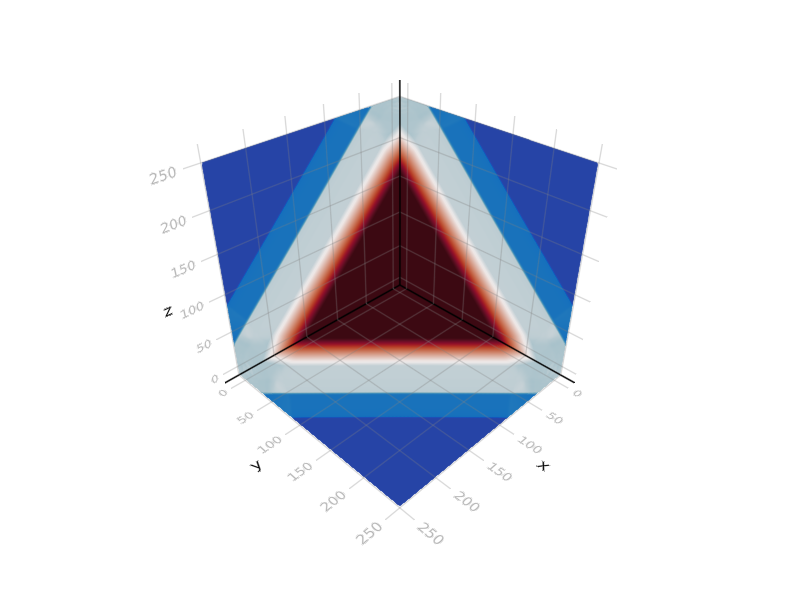

In [10]:
w = Array(prob.sol.W);
wl= Array(prob.tmp.wl);
wr= Array(prob.tmp.wr);
 F= Array(prob.flux.F);
IDN,IEN,IPR  = prob.grid.ind.ρ::Int ,prob.grid.ind.e::Int ,prob.grid.ind.P::Int ;
IVX,IVY,IVZ  = prob.grid.ind.v₁::Int,prob.grid.ind.v₂::Int,prob.grid.ind.v₃::Int;
is,ie = prob.grid.x1.is::Int,prob.grid.x1.ie::Int;
js,je = prob.grid.x2.js::Int,prob.grid.x2.je::Int;
ks,ke = prob.grid.x3.ks::Int,prob.grid.x3.ke::Int;

d =  w[is:ie,js:je,ks:ke,IDN];
GLMakie.activate!() # hide
inline!(true) # hide

colormap = Makie.to_colormap(:balance)
colormap[1] = RGBAf0(0.0,0.0,0.0,0.0)
scene = GLMakie.volume(d,algorithm =:mip,  absorption=0.1, colormap=colormap, transparency=true, shininess =0.0)
scene

In [9]:
prob.debugTimer

 ────────────────────────────────────────────────────────────────────────────────
                                        Time                    Allocations      
                               ───────────────────────   ────────────────────────
       Tot / % measured:            70.3s /  95.2%           3.98GiB /  56.4%    

 Section               ncalls     time    %tot     avg     alloc    %tot      avg
 ────────────────────────────────────────────────────────────────────────────────
 Time Stepper             200    60.4s   90.1%   302ms   1.43GiB   63.5%  7.30MiB
   Flux intregation       400    50.8s   75.9%   127ms   1.06GiB   47.2%  2.71MiB
     Reconstruct dir x    400    12.1s   18.1%  30.3ms    363MiB   15.8%   928KiB
     Reconstruct dir y    400    10.1s   15.1%  25.3ms    130MiB    5.7%   334KiB
     Reconstruct dir z    400    9.85s   14.7%  24.6ms    130MiB    5.7%   334KiB
     Solver dir x         400    5.37s    8.0%  13.4ms    184MiB    8.0%   471KiB
     Solver dir